In [1]:
import matplotlib
import numpy as np
from matplotlib.mlab import griddata
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import math
from scipy.spatial import KDTree
import time
import scipy.ndimage as ndi

%matplotlib inline

In [2]:
pointsPrac = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay
tri = Delaunay(pointsPrac)

print (tri)

tri.vertices

array([[3, 1, 0],
       [2, 3, 0]], dtype=int32)

#### Convex Hull:
---------------

A convex hull of a set of points is the uniquely defined shape that minimizes the area that contain all the points, ***without having any angle that exceed 180 degrees between two neighbouring edges,***

In [3]:
import random
from scipy.spatial import ConvexHull

random.seed(7862)
points = np.random.rand(30, 2)
hull = ConvexHull(points)
print (hull)

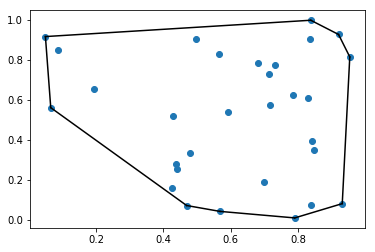

In [4]:
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

#### Delaunay:

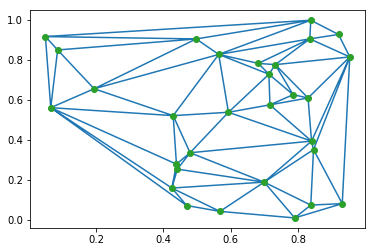

In [5]:
tri = Delaunay(points)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [6]:
tri.simplices

array([[29,  2,  1],
       [27, 29,  1],
       [22, 24, 18],
       [15,  0,  4],
       [15, 27,  0],
       [27, 15, 29],
       [14,  5, 18],
       [ 5, 14,  0],
       [27,  5,  0],
       [ 2,  9,  1],
       [28, 15,  4],
       [15, 28, 29],
       [ 2, 28,  4],
       [29, 28,  2],
       [26, 16, 27],
       [16,  5, 27],
       [22, 19, 24],
       [11, 19, 22],
       [24, 19, 10],
       [19, 11, 10],
       [11, 20, 10],
       [ 3, 23, 26],
       [ 3, 27,  1],
       [ 3, 26, 27],
       [25, 12,  2],
       [12,  9,  2],
       [20, 12, 25],
       [12, 20, 11],
       [ 6, 16, 26],
       [16,  6,  5],
       [ 5,  6, 18],
       [ 6, 17, 18],
       [ 3, 21, 23],
       [21, 17, 23],
       [21, 11, 22],
       [21, 22, 18],
       [17, 21, 18],
       [21, 13, 11],
       [13, 21,  3],
       [ 9, 13,  1],
       [13,  3,  1],
       [23,  7, 26],
       [17,  7, 23],
       [ 7,  6, 26],
       [ 6,  7, 17],
       [ 8, 12, 11],
       [12,  8,  9],
       [13,  

### Concave Hull (Alpha Shape) in detaiil:
----------

A concave hull of a set of points could be defined as the shape which minimizes the area of the containing shape, but allowing any angle between the edges. Usually we don’t want the minimal area since that can easily distort a figure

The Delaunay triangulation creates non-overlapping traingles such that no point lies inside the circumference of the traingle. It also avoid any triangle with smaller angles. 

* tri.vertices: After forming all the traingles it names all the verticles of the traingles with 0-n numbers. tri.vertices would produce the vertices of the triangles. For example, A four point dataset would have 4 vertices v1,v2,v3,v4 and two tringles, where traingle 1 contains v1,v2,v3 and triangle 2 contains vertices v3,v4,v1. So the output of tri.vertices would be [[v1,v2,v3],[v3,v4,v1]]. This however can be in any order


In [7]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay, distance
import shapely.geometry as geometry
from sklearn import metrics

import pandas as pd
import numpy as np
import math


import pylab as pl


from descartes import PolygonPatch
def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig


class polygonArea():

    def __init__(self):
        self.edges =  set()
        self.edge_points = []
        
    def add_edge(self, coords, i, j):
            """
                Add an edge between two near vertices if not already exists
            """
            if (i, j) in self.edges or (j, i) in self.edges:
                return
            self.edges.add((i, j))
            self.edge_points.append(coords[ [i, j] ])

#     def convex_hull():
        
    def alpha_shape(self, points, alpha):
        """
            Compute the alpha shape (concave hull) of a set
            of points.

            Inputs: Points - The input 2D points
                    alpha  - A sort of threshold to trade off between concave Hull and Convex Hull
                            The more the value of alpha the more less the area of the polygon connecting points (high order conccave hull)
                            The less the value of alpha the less the area of the polygon connection points (Convex hull)
            Output: edge_points - Edge points extracted based on the input alpha value.
        """
        if len(points) < 4:
            # When you have a triangle, there is no sense
            # in computing an alpha shape.
            return geometry.MultiPoint(list(points)).convex_hull

        # Find all the non overlapping triangle
        coords = np.array(points)
        tri = Delaunay(coords)
        l= 1
        for ia, ib, ic in tri.vertices:
            # Calculate the Lengths of sides of triangle (This is simply the euclidean distance)
            a = metrics.pairwise.euclidean_distances(coords[ia].reshape(1, -1) , coords[ib].reshape(1, -1))[0][0]
            b = metrics.pairwise.euclidean_distances(coords[ib].reshape(1, -1) , coords[ic].reshape(1, -1))[0][0]
            c = metrics.pairwise.euclidean_distances(coords[ic].reshape(1, -1) , coords[ia].reshape(1, -1))[0][0]

            # Find Area of triangle by Heron's formula
            # Semiperimeter of triangle, half of teh total perimeter
            s = (a + b + c)/2.0
            area = math.sqrt(s*(s-a)*(s-b)*(s-c))
            circum_r = a*b*c/(4.0*area)

            # The more the distance between points a,b,c the more will be the circum_r
            # This step will basically avoid connecting far edges, which are mostly 
            # a result of convex hull. In other words if the points are near to each other 
            # till a certain threshold only then the edges are retained between each vertices.
            if circum_r < 1.0/alpha:
                self.add_edge(coords, ia, ib)
                self.add_edge(coords, ib, ic)
                self.add_edge(coords, ic, ia)
    
        # edge_points are the points that qualifies the given alpha value. A Edge point 
        m = geometry.MultiLineString(self.edge_points)
        triangles = list(polygonize(m))

        
        # Cascade_union will remove all the tringle edge that are not at the exterior
        # and only keep the once that are the outer most edges, hence creating a single
        # Polygon. this is also a good way to plot
        return cascaded_union(triangles)#, self.edge_points



concaveHull = polygonArea().alpha_shape(points,alpha=2.5)
print ('The Area of the concave Hull is: ', concaveHull.area)

# _ = plot_polygon(concaveHull)
# _ = pl.plot(points[:,0],points[:,1],'o', color='#f16824')


print (concaveHull)
# alpha_shape(points, 0.1)

The Area of the concave Hull is:  0.6283926302297084
POLYGON ((0.9309037173406653 0.07996976748619811, 0.7898126585361217 0.008403776570116817, 0.5679214303268326 0.04109339961360592, 0.4690926737680341 0.07052266989016498, 0.4251324944347936 0.1579743209831149, 0.06579791894164788 0.5605423673107039, 0.04995211755235351 0.9165511501520125, 0.4975350114246844 0.9047198539519173, 0.8374481098276549 0.9983338439021107, 0.9198906788137614 0.9270872716794096, 0.9532516392183188 0.8146288244081883, 0.8397517746090786 0.3930069151812716, 0.8456485349116465 0.3505444792006071, 0.9309037173406653 0.07996976748619811))


In [8]:
type(concaveHull)

shapely.geometry.polygon.Polygon

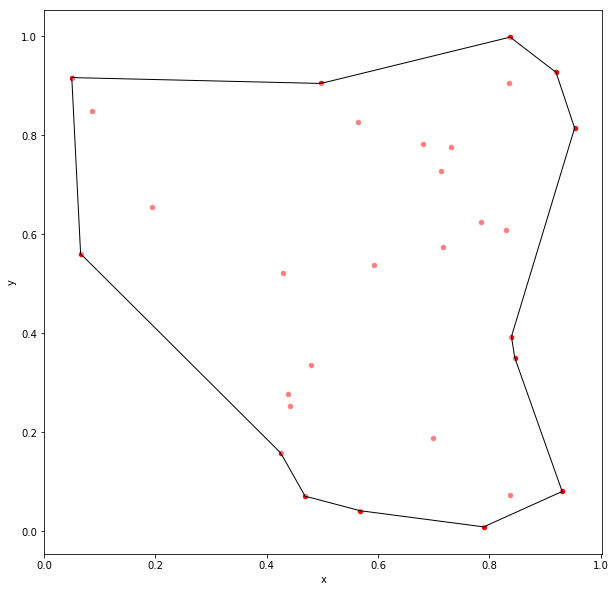

In [9]:
import geopandas as gpd


class GlobalPlot(object):
    def __init__(self):
        pass
        
    def get_Plot_info(self):
        plotInfo = dict(
            plot_type = 'scatter, histogram2Dcontours',
            plot_mode = "lines, markers, lines+markers, lines+markers+text",
            marker_conf = dict(
                size = '3 to 10',
                opacity = '0.3 to 0.7',
                color = 'black, white , etc. When using group on a third column then pass in the column values;',
                colorscale ='Viridis etc. Use when performing a group by on a third column values. Optimal when many values in 3rd column',
                showscale = 'True or False : Should you choose to activate the color scale or not'
            )
        ) 
        
        return plotInfo
        
    def get_GeoPlot_info(self):
        pass
    
    def set_figure(self):
        pass
    
    def base_plot(self):
        pass
    
    def add_plot(self):
        pass
    
    
    
class GeoPlot():
    def __init__(self):
        GlobalPlot.__init__(self)
        self.newPlot = None
        self.basePlot = None
        self.axPointer = None
        
        # We basically make a default subplot, However this can be overridden by calling
        # the set_figure function
        self.fig, self.ax = plt.subplots(1,1, 
                                         figsize=(10, 10), 
                                         facecolor='w', edgecolor='k')
        
    def set_figure(self, numRows=1, numColumns=1, lenXaxis=40, lenYaxis=15):
        self.fig, self.ax = plt.subplots(numRows, 
                                         numColumns, 
                                         figsize=(lenXaxis, lenYaxis), 
                                         facecolor='w', edgecolor='k')
        if numRows>1 or numColumns>1:
            self.ax = self.ax.ravel()
            self.axPointer = 0
            
            
    def set_data(self, dataIN):
        self.dataIN = dataIN
        
    def base_plot(self, color='white', dataIN=[]):
        if any(dataIN):
            self.dataIN = dataIN
            
        if self.axPointer != None:
            self.basePlot = self.dataIN.plot(ax=self.ax[self.axPointer], color=color)
            self.axPointer += 1
        else:
            self.basePlot = self.dataIN.plot(ax=self.ax, color=color)
            
    def add_plot(self, dataIN):
        dataIN = pd.DataFrame({'x':dataIN.iloc[:,0], 'y':dataIN.iloc[:,1]})
        if self.newPlot == None:
            self.newPlot = dataIN.plot(x='x', y='y', kind='scatter', ax=self.basePlot, color='red')
        else:
            # When plotting the third layer
            self.newPlot = dataIN.plot(x='x', y='y', kind='scatter', ax=self.newPlot, color='red') 
        
s = gpd.GeoSeries(concaveHull)
geo_df = gpd.GeoDataFrame(geometry=s)            
onj_plot = GeoPlot()
onj_plot.set_data(geo_df)
onj_plot.base_plot()
onj_plot.add_plot(pd.DataFrame({'x':points[:,0], 'y': points[:,1]}))
#{'concave_hull':concaveHull})

In [10]:
points[:,1]

array([ 0.99833384,  0.52060407,  0.56054237,  0.53747565,  0.91655115,
        0.90511845,  0.77594692,  0.62553871,  0.25270024,  0.27770733,
        0.00840378,  0.18766553,  0.15797432,  0.33477212,  0.92708727,
        0.90471985,  0.78227565,  0.60909848,  0.81462882,  0.07268464,
        0.0410934 ,  0.39300692,  0.35054448,  0.57467521,  0.07996977,
        0.07052267,  0.72792827,  0.82708788,  0.84953015,  0.65516212])

In [11]:
points[:,0]

array([ 0.83744811,  0.42910909,  0.06579792,  0.59309885,  0.04995212,
        0.83466394,  0.73205985,  0.78503507,  0.44151604,  0.43886323,
        0.78981266,  0.69911946,  0.42513249,  0.47927896,  0.91989068,
        0.49753501,  0.68169222,  0.82944422,  0.95325164,  0.83749439,
        0.56792143,  0.83975177,  0.84564853,  0.71619495,  0.93090372,
        0.46909267,  0.71337244,  0.56431277,  0.08621373,  0.19445149])